In [1]:
import sys
import os
import numpy as np
result_dirs = './recode/Simulation/'

In [2]:
datasets_dirs = os.listdir(result_dirs)
softs = ['spanve-k','spanve-d','sepal','somde','moran','geary','r-gitto-sirank','r-sparkx','r-gitto-rank','r-meringue','spatialde'] 
sys.path.append('./Softs/')

# Utils

In [3]:
import re

def parse_memory_file(memory_file):
    pattern = re.compile(r'(\d+)maxresident')
    with open(memory_file) as f:
        content = f.read()
        cost = int(pattern.findall(content)[0])
    return cost

def parse_time_log(log_file):
    pattern = re.compile(r'time cost:[\s]{0,1}(\S+)')
    with open(log_file) as f:
        content = f.read()
        cost = float(pattern.findall(content)[0])
    return cost

In [4]:
import pickle
def load_spanve_model(file_path):
    from Spanve import Spanve
    with open(file_path,'rb') as f:
        model = pickle.load(f)
    return model

# Main

In [6]:
import pandas as pd

recoder = pd.DataFrame()
for dataset in datasets_dirs:
    for soft_name in softs:
        try:
            file_path = os.path.join(dataset,soft_name)
            memory_file = os.path.join(result_dirs,file_path,'memory_info.txt')
            log_file = os.path.join(result_dirs,file_path,'run.log')
            mem_cost = parse_memory_file(memory_file)
            time_cost = parse_time_log(log_file)
        except:
            continue

        recoder.loc[len(recoder),['dataset','soft','memory','time']] = [dataset,soft_name,mem_cost,time_cost]

        n = int(dataset.split('_')[1])**2
        r = float(dataset.split('_')[2])

        recoder.loc[len(recoder)-1,['n','randomness']] = int(n),r
    
    
recoder['memory']/=1024

# recoder['time'] = np.log10(recoder['time'])
# recoder['memory'] =np.log10(recoder['memory'])

In [7]:
recoder['soft'] = recoder['soft'].map(
    {
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal',
        'r-gitto-sirank':'Gitto-siRank',
        'spatialde':'SpatialDE',
        'r-meringue':'MERINGUE'
    }
)

recoder = recoder.sort_values(by=['n'])

In [10]:
recoder

,dataset,soft,memory,time,n,randomness
139,Sim_10_0.1_10.h5ad,SPARK-X,442.085938,10.121603,100.0,0.1
148,Sim_10_0.2_925.h5ad,Geary test,404.089844,6.356545,100.0,0.2
147,Sim_10_0.2_925.h5ad,Moran test,408.800781,5.844069,100.0,0.2
146,Sim_10_0.2_925.h5ad,SOMDE,196.351562,71.324074,100.0,0.2
145,Sim_10_0.2_925.h5ad,sepal,192.324219,5.971619,100.0,0.2
...,...,...,...,...,...,...
99,Sim_300_0.0_431.h5ad,SOMDE,2965.046875,271.919538,90000.0,0.0
98,Sim_300_0.0_431.h5ad,sepal,186295.523438,507.394020,90000.0,0.0
97,Sim_300_0.0_431.h5ad,Spanve-d,1390.863281,18.070412,90000.0,0.0
351,Sim_300_0.2_871.h5ad,SPARK-X,6780.824219,50.439505,90000.0,0.2


In [11]:
recoder.columns = ['data_file','soft','Max Resident Memory(Mb)','time(sec)','n_cells','simulation_param']
recoder.to_csv('./Results/Time_mem_cost.csv',index=False)

In [6]:
order = recoder[recoder['n']==10000].groupby('soft')['time'].mean().sort_values().index.values.tolist()
recoder['n'] = recoder['n'].map(
    {100:"10$^2$",
    900:"30$^2$",
    2500:"50$^2$",
    6400:"80$^2$",
    10000:"100$^2$",
    22500:"150$^2$",
    40000:"200$^2$",
    62500:"250$^2$",
    90000:"300$^2$"}
)

[Text(0, 0.5, 'Max Resident Memory (Mb)')]

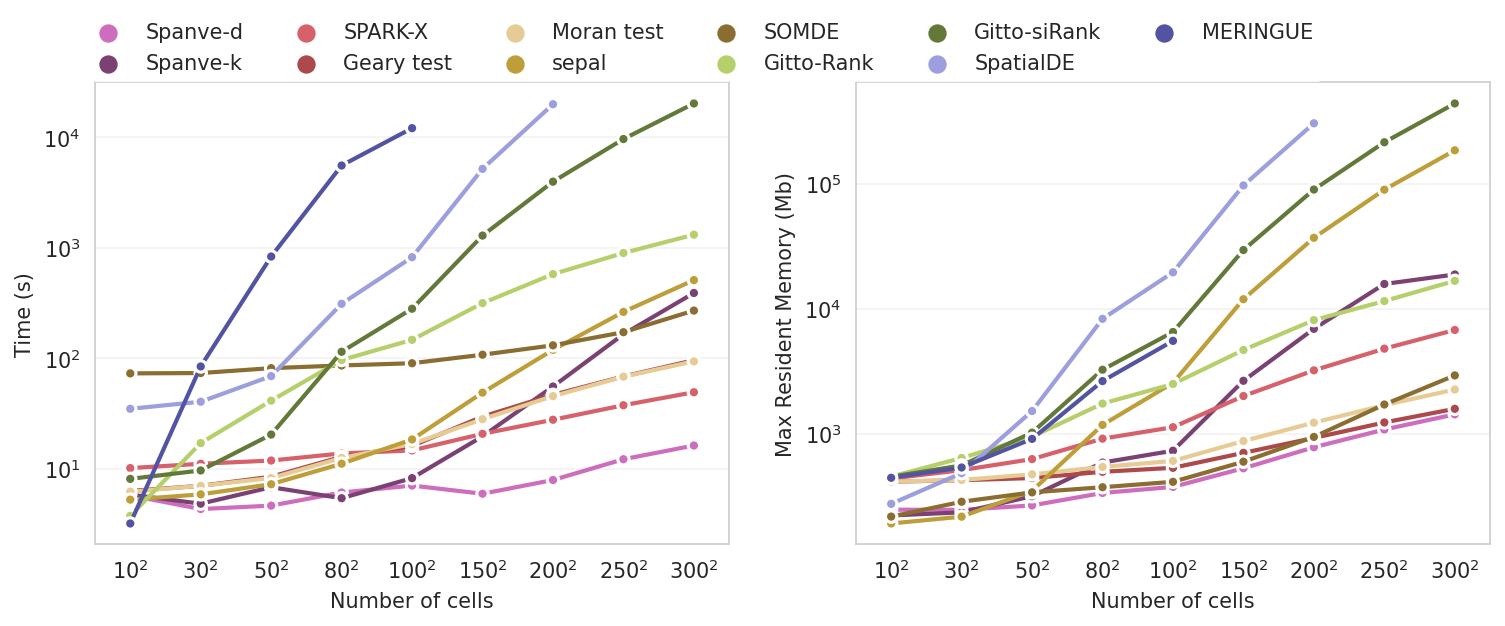

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='whitegrid')
sns.set_style(style={'grid.color': '.95',})

color_map ='tab20b_r' #sns.diverging_palette(220,10,n=12,l=50,s=65)

f,axes = plt.subplots(1,2,dpi=150,figsize=(12,4))

g0 = sns.pointplot(
    data=recoder, x="n", y="time", hue="soft",
    palette=color_map,ax = axes[0],
    errorbar=('ci', False),
    hue_order=order
)
g0.legend_.set_visible(False)
g0.set(yscale="log")
g0.set(xlabel="Number of cells")
g0.set(ylabel="Time (s)")

for i in range(len(g0.lines)):
    g0.lines[i].set_linewidth(2)
for i in g0.collections:
    i.set_sizes([30 for _ in range(9)])
    i.set_edgecolor('white')
    i.set_lw(1.5)

g1 = sns.pointplot(
    data=recoder, x="n", y="memory", hue="soft",
    palette=color_map,ax = axes[1],
    errorbar=('ci', False),
    hue_order=order,
)
g1.legend(bbox_to_anchor=[0.75,1.17],edgecolor='white',ncols=6)
g1.set(yscale="log")
for i in range(len(g1.lines)):
    g1.lines[i].set_linewidth(2)
for i in g1.collections:
    i.set_sizes([30 for _ in range(9)])
    i.set_edgecolor('white')
    i.set_lw(1.5)
g1.set(xlabel="Number of cells")
g1.set(ylabel="Max Resident Memory (Mb)")


In [12]:
f.savefig('./Results/Time_mem_cost.pdf',bbox_inches='tight')